# CS146 Problem Set 1
## Call center data modeling & other exercises

## Problem 1: Call center data modeling 
### LOs: #PythonImplementation, #interpretingProbabilities
Task1 : Compute a 98% posterior confidence interval over the number of calls per minute (the call rate lambda) for each hour of the data which will lead in 24 confidence intervals. 

Task2 : Compute the posterior mean of lambda for each hour of the day.

Task 3 : Present the results graphically. 

Task 4 : Write a paragraph to accompany you plot and present your findings to the client. (Summarize how many calls you expect during different parts of the day, and how much uncertainty there is in your estimates.)

In [4]:
#import the libraries that we need for the task
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
%matplotlib inline

From the preclass and class activities of session 4, load the data and re-form the data for us to use (Codes Reused)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093
00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


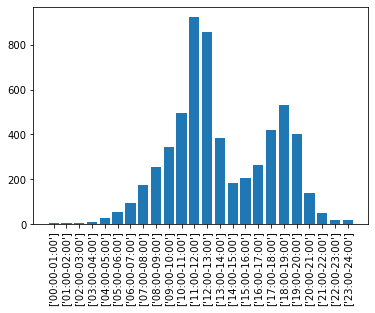

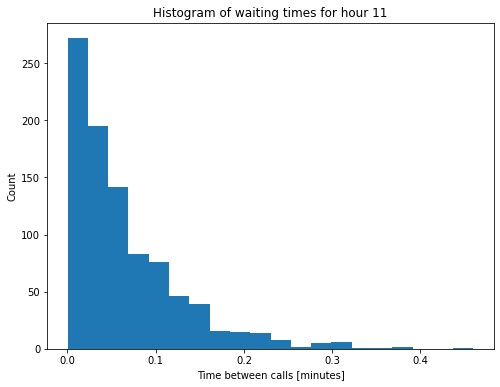

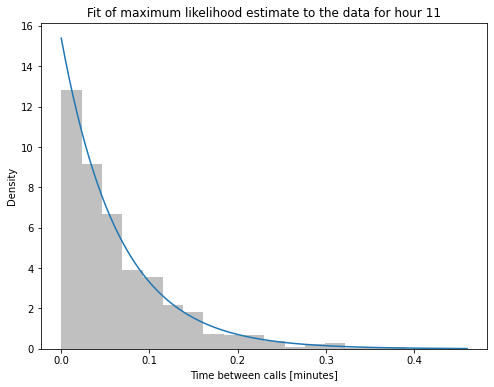

In [27]:
#Let's load the data
waiting_times_day = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/'
    '00124343-8397/call-center.csv')

#Display the basics of the Data
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

#data pre-processing
#from the preclass work from before, make 24 hrs list of waiting times per hour
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

table_time = []
table_calls = []
for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    print(f'{hour:02}:00-{hour + 1:02}:00 - {len(calls_in_hour)} calls')
    table_time.append([f'{hour:02}:00-{hour + 1:02}:00'])
    table_calls.append([len(calls_in_hour)])

#show the data
#from above task, we have the data. Plot the graph of numbers of calls in specific time intervals
plt.bar(list(range(24)), [int(i) for i in np.array(table_calls)])
plt.xticks(list(range(24)),table_time, rotation = 90)
plt.show()

# Plot histogram of waiting times for one hour
hour_index = 11
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')

#fit the likelihood
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0') #to make the distribution to have 1 as the total area, density = true
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

For it to be done correctly, we have to define what distributions that we would like to use for likelihood and prior probability. Here, our task is to see the number of calls in certain period of time, which is always positive and always a natural number (positive integer). From the class, we have chosen exponential distribution for the likelihood because of this characteristic of the variable, but also because we can use a single variable lambda to represent the rate of the calls(lambda) for the distribution as exponential distribution is used for modeling the time between the events(calls). From the class, we have discussed about this by looking at the certain time duration's histogram we saw the exponential distribution to back up with the idea.(We could have done gamma, but that would mean that we need to consider two hyperparameters when we can just live with estimating only one)

Now considering that the likelihood is exponential distribution, we also in the class, have used gamma distribution as the conjugte prior distribution so that we can easily define the posterior distribution which will become gamma distribution with a new hyper parameters that prior and the data makes (such as alpha for posterior will be alpha of prior + size of the data).

As I have no idea what will the hyperparameter of the prior will be, I would like to stick with the value that we have done during the class. Alpha = 1, beta = 0.25

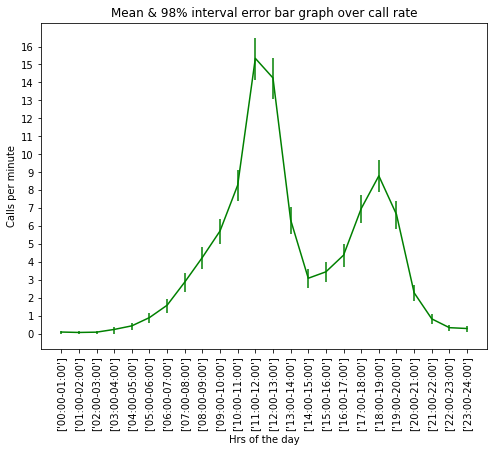

In [47]:
#Hyperparameter_prior
a_0 = 1
b_0 = 0.25

#Make an empty list to save the values of the posterior parameter
a_post = list()
b_post = list()

#from given data and parameter of prior, we can calculate the parameter of the posterior (gamma dist)
#calculations are based from given link : https://en.wikipedia.org/wiki/Conjugate_prior
for i in range(len(waiting_times_per_hour)): 
    a_post.append(a_0 + len(waiting_times_per_hour[i])) #a_post = a_0 + n
    b_post.append(b_0 + sum(waiting_times_per_hour[i])) #b_post = b_0 + sum of x from 1 to n

#gamma distribution for posterior (as we now have the parameter, we can draw the distribution)
#we need mean, 98% intervals to plot them.
posterior_dist = [] #have graphs as elements
post_mean = [] #mean of each time section gonna be saved as lists
post_upper = [] #upperbound of 98% interval
post_lower = [] #lowerbound of 98% interval

#draw graph using parts of the codes from class session 4
plt.figure(figsize = (8,6))
plt.xlabel('Hrs of the day')
plt.ylabel('Calls per minute')
plt.title('Mean & 98% interval error bar graph over call rate')

for i in range(len(a_post)):
    posterior = sts.gamma(a = a_post[i], scale = 1/b_post[i]) #for each hyperparameter of that time slot, draw a gamma dist
    posterior_dist.append(posterior)
    post_mean.append(posterior.mean())
    #calculating 98%interval from sample data: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    post_upper.append(posterior.ppf((1+0.98)/2) - posterior.mean()) 
    post_lower.append(posterior.mean()-posterior.ppf((1-0.98)/2))
    
plt.xticks(list(range(24)),table_time, rotation = 90)
plt.yticks(list(range(17)))
plt.errorbar(list(range(24)), post_mean, yerr = (post_upper, post_lower), color = 'green')
plt.show()
    

Now we know that there are two modes where the call rate surges around 11am and 6pm, it is evident that there needs to be more call respondents for this time duration. But as the confidence interval can vary up to a bit more than +- 1, having the 'mean' as the criteria for number of respondents are not ideal, which might cause some customers to wait if the call rates are bigger than the mean at the expected moment. So, by considering 98% interval as the boundary, we need to see the upper bound for making the choice of allocating the number of respondents at the time for the sake of saving customers' waiting time.

## Problem 2: Bent coin inference
### LOs: #BayesInference

A normal coin has a probability of 0.5 of coming up heads when it is flipped. In this problem, we consider a bent coin that has an unknown probability of coming up heads. You flip the coin 20 times and the coin comes up heads 6 times. Now calculate the probability that the coin is biased in favor of heads by addressing all the questions and tasks below.

1. Let pi denote the probability that the bent coin comes up heads when flipped.

2. Use a binomial distribution for the likelihood function and a beta distribution for the prior over pi (likelihood - binomial dist, prior - beta, according to the wikipiedia[https://en.wikipedia.org/wiki/Conjugate_prior], I will calculate)

3. Select and motivate for your choice of parameters for the prior distribution (as I have no idea how bent the coin is, I want to use uniform distribution so that the data can dictate the outcome, which means that I am giving equal chance for any pi to be possible from prior distribution. This results alpha = 1, beta = 1 for prior to have under the x_axis interval of 0 to 1 as pi is going to be a probability.)

4. Using the observations above (6 heads out of 20 coin flips), compute the exact posterior distribution over pi

5. Plot the posterior distribution over pi and show a 95% credible interval of pi on the plot.

6. Compute the probability that the coin is biased in favor of heads - that it is more probable for the coin to come up heads rather than tails. 

In [9]:
#for calculating 95% percentile, from the class, this was from professor's code
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

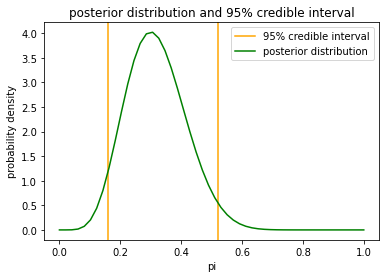

[0.16, 0.52]


In [56]:
#calculate and plot posterior

#parameters of prior
a0 = 1 #alpha of beta dist
b0 = 1 #beta of beta dist

#posterior distribution calc
a1 = a0 + 6 #new alpha for posterior given the data : 6heads out of 20 trials
b1 = b0 + 20 - 6 #new beta for posterior given the data
posterior = sts.beta.pdf(np.linspace(0,1,50), a1, b1)

#calculate 95% interval using the codes from the class
percentiles = [compute_percentile(np.linspace(0,1,50), posterior, p ) for p in [0.025, 0.975]]

#plot the posterior and 95% credible interval
plt.title('posterior distribution and 95% credible interval')
plt.axvline(percentiles[0], color = 'orange')
plt.axvline(percentiles[1], color = 'orange', label = '95% credible interval')
plt.plot(np.linspace(0,1,50), posterior, color = 'green', label = 'posterior distribution')
plt.xlabel('pi')
plt.ylabel('probability density')
plt.legend()
plt.show()

print(percentiles)

This means that for the probability to have the coin biased to have more heads than tails is less than 2.5% from given data as the 95% interval upper boundary given above states 0.52 which is near 0.5 that is when heads and tails are both equally likely to happen. (bigger the pi, higher the probability for heads to come. right side of the green graph's area from \[0.52, 1\] is less than 2.5% is what I mean)